# Clustering methods applied to FTS transfer error messages

**Objective:** 

 - extract FTS transfer error data
 - load language model
 - perform cluster analysis

### Spark Session 

In [1]:
%%time

# start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("fts_clustering").getOrCreate()
#spark = SparkSession.builder.master("local[*]").appName("fts_data").getOrCreate()
spark

CPU times: user 50.8 ms, sys: 25.6 ms, total: 76.4 ms
Wall time: 9.25 s


## Import data

**Note:** the period 7/10 - 10/10 is considered since there should be an issue with an FTS instance and we want our approach to be able to spot it.

In [2]:
# train_data = spark.read.csv("train_subsample.csv", header=True)

test_data = spark.read.csv("test_data.csv", header=True)

## Pre-processing 

In [3]:
def deal_with_urls(url):
    from urllib.parse import urlparse
    parsed = urlparse(url)
    if parsed.scheme:
        if parsed.path and parsed.netloc:
            res = ' '.join([parsed.scheme + "://" + parsed.netloc, parsed.path])
        elif parsed.path:
            res = parsed.scheme + ":" + parsed.path
        else:
            res = parsed.scheme + ":"
    elif parsed.params:
        res = ' '.join([parsed.path.strip("."), parsed.params])
    else:
        res = parsed.path
    return(res)

def split_urls(string):
    '''Take a string and split url into netloc + path'''
    from urllib.parse import urlparse
    tks = [deal_with_urls(x) for x in string.split()]
    return(' '.join(tks))


def split_concatenation_errors(string, split_char="-"):
    """"""   
    if split_char in string:
        try:
            int(string.split(split_char)[0])
            number = string.split(split_char)[0]
            literal = string.replace(number+split_char, "")
            return([number, literal])
        except ValueError:
            return(string)
    else:
        return(string)

def clean_tokens(entry, custom_split=False):
    """Remove punctuation at the end of tokens and disard empty tokens"""
    def flatten(ul):
        """"""
        fl = []
        for i in ul:
            if type(i) is list:
                fl += flatten(i)
            else:
                fl += [i]
        return fl
    
    if custom_split:
        tks_cleaned = [split_concatenation_errors(tks.strip(":;,.- ")) 
                       for tks in entry if tks!=""]
        tks_cleaned = flatten(tks_cleaned)
    else:
        tks_cleaned = [tks.strip(":;,.- ") for tks in entry if tks!=""]
    return(tks_cleaned)

In [4]:
import pyspark.sql.functions as F

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType

# transform in user defined function
split_urls_udf = udf(split_urls, StringType())

# split urls appropriately
# test_data = test_data.select("t__error_message").withColumn("corrected_message", split_urls_udf("t__error_message"))
test_data = test_data.select("t__error_message").distinct().withColumn("corrected_message", split_urls_udf("t__error_message"))

# add row id
test_data = test_data.withColumn("msg_id", F.monotonically_increasing_id()).select("msg_id", "t__error_message", "corrected_message")

In [5]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# split text into tokens
tokenizer = Tokenizer(inputCol="corrected_message", outputCol="tokens")
vector_data = tokenizer.transform(test_data)

# transform in user defined function
clean_tokens_udf = udf(lambda entry: clean_tokens(entry, custom_split=True), ArrayType(StringType()))

# clean tokens
vector_data = vector_data.withColumn("tokens_cleaned", clean_tokens_udf("tokens"))

# remove stop (common, non-relevant) words
stop_remove = StopWordsRemover(inputCol="tokens_cleaned", outputCol="stop_token")
stop_remove1 = StopWordsRemover(inputCol="stop_token", outputCol="stop_token_1", stopWords=["", ":", "-", "+"])

In [6]:
from pyspark.ml import Pipeline

data_prep_pipeline = Pipeline(stages = [stop_remove, stop_remove1])

pipeline_executor = data_prep_pipeline.fit(vector_data)

In [7]:
%%time

vector_data = pipeline_executor.transform(vector_data)

CPU times: user 58.4 ms, sys: 11.5 ms, total: 69.9 ms
Wall time: 201 ms


In [8]:
vector_data.count()

173920

In [9]:
# subsample data
sub1 = vector_data.sample(withReplacement=False, fraction=0.3, seed=4)

<div class="alert alert-block alert-info">
    <b>Note:</b> I should probably scale the stop_words column before feeding it into word2vec model.
</div>

In [ ]:
# from pyspark.ml.feature import StandardScaler
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# # Compute summary statistics by fitting the StandardScaler
# scalerModel = scaler.fit(final_data)

# # Normalize each feature to have unit standard deviation.
# cluster_final_data = scalerModel.transform(final_data)

## Custering 

In [10]:
# load back the word2vec model
from pyspark.ml.feature import Word2VecModel
w2vec_model = Word2VecModel.load('word2vec_trial_random_sample')

# apply it to the data to obtain the embedded representation
# train_data = sub1.select("msg_id", "t__error_message", "stop_token_1")#.limit(500000)
train_data = vector_data.select("msg_id", "t__error_message", "stop_token_1")#.limit(500000)
train_data = w2vec_model.transform(train_data)

In [11]:
# from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [12]:
vec_assembler = VectorAssembler(inputCols = ["message_vector"], outputCol='features')

In [13]:
# format data to feed it into pyspark ML models
train_data = vec_assembler.transform(train_data)

In [14]:
train_data.limit(1).show(truncate=False)

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### K-Means 

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [56]:
%%time

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

kmeans_models = []
clustering_model = []
wsse = []
silhouette = []


k_list = []
for i, k in enumerate(range(5,20)):
    k_list.append(k)
    kmeans_models.append(KMeans(featuresCol='features',k=k, initMode='k-means||',
    initSteps=3, tol=0.0001, maxIter=30, distanceMeasure='cosine'))
    clustering_model.append(kmeans_models[i].fit(train_data))
    
    # compute metrics   
    wsse.append(clustering_model[i].summary.trainingCost)
    silhouette.append(evaluator.evaluate(clustering_model[i].summary.predictions))

    print("With K={}".format(k))
    print("Within Cluster Sum of Squared Errors = " + str(wsse[i]))
    print("Silhouette with cosine distance = " + str(silhouette[i]))
    print('--'*30)

With K=5
Within Cluster Sum of Squared Errors = 51666.797652992296
Silhouette with cosine distance = 0.7007597856536323
------------------------------------------------------------
With K=6
Within Cluster Sum of Squared Errors = 42417.31205646741
Silhouette with cosine distance = 0.7111873049898064
------------------------------------------------------------
With K=7
Within Cluster Sum of Squared Errors = 37286.29843675361
Silhouette with cosine distance = 0.7406978350996407
------------------------------------------------------------
With K=8
Within Cluster Sum of Squared Errors = 37288.9105021556
Silhouette with cosine distance = 0.7363599013292254
------------------------------------------------------------
With K=9
Within Cluster Sum of Squared Errors = 33573.11620055456
Silhouette with cosine distance = 0.7376167730323601
------------------------------------------------------------
With K=10
Within Cluster Sum of Squared Errors = 34740.83131667538
Silhouette with cosine distance =

##### Saving clustering models 

In [43]:
for i, model in enumerate(kmeans_models):
    model.write().overwrite().save("kmeans_k{}_unique".format(model.getK()))

In [44]:
for i, model in enumerate(clustering_model):
    model.write().overwrite().save("kmeans_k{}_trained_unique".format(model.summary.k))

#### Choice of K

In order to choose the optimal value for the number of clusters, K, I compare the results obtained with different Ks based on two indicators:
 - Sum of Squared Distances Within Groups: $$ \text{WSSE}(\text{dist}, K) = \sum_{k=1}^{K}{\sum_{x_i \in C_k}\text{dist}(x_i, \overline{x}_k)}$$
 
 - Average Silhouette Width: $$ \text{ASW}(\text{dist}, K) = \frac{1}{n} \sum_{i=1}^{n}{\frac{b(i) - a(i)}{\text{max}[a(i), b(i)]}}$$
 where $a(i)$ is the average distance of message $i$ to all the other messages in the same cluster and $b(i)$ is the minimum average distance of message $i$ from messages on another cluster.
 
 $$$$

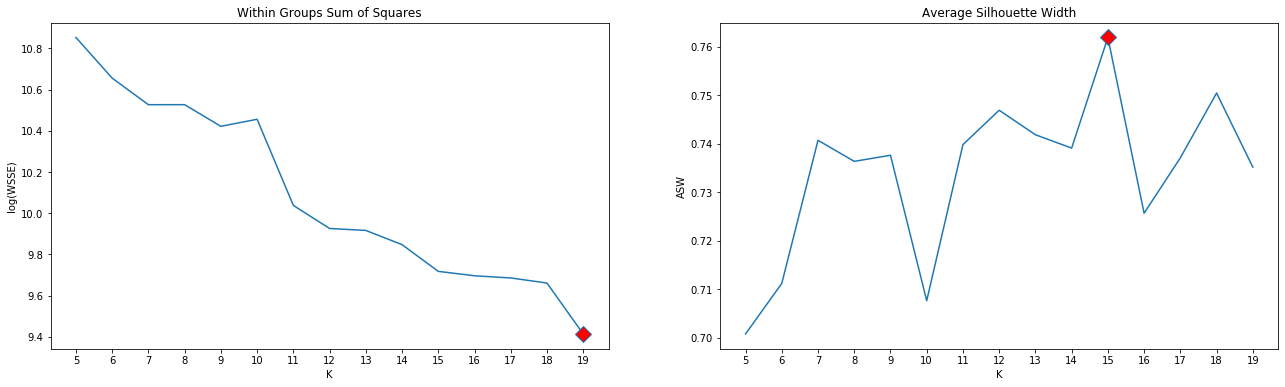

In [130]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(22,6))

best_K_wsse = np.argmin(wsse)
best_K_silhouette = np.argmax(silhouette)

_ = plt.subplot(1,2,1)
_ = plt.plot(k_list, np.log(wsse),'-D', markevery=[best_K_wsse], markerfacecolor='red', markersize=12)
# _ = plt.Circle(xy=(16,16257), radius=3, color="red")
_ = plt.xlabel("K")
_ = plt.ylabel("log(WSSE)")
_ = plt.xticks(k_list)
_ = plt.title("Within Groups Sum of Squares")

_ = plt.subplot(1,2,2)
_ = plt.plot(k_list, silhouette,'-D', markevery=[best_K_silhouette], markerfacecolor='red', markersize=12)
_ = plt.xlabel("K")
_ = plt.ylabel("ASW")
_ = plt.xticks(k_list)
_ = plt.title("Average Silhouette Width")


#### Posterior checks 

In [113]:
# from pyspark.ml.clustering import KMeansModel

# clustering_model = []
# for k in [4,8,12]:
#     clustering_model.append(KMeansModel.load("kmeans_k{}_trained".format(k)))

In [131]:
import numpy as np

for model in clustering_model:
    print("\n\nkmeans: K = {}".format(model.summary.k))
    print("Maximum number of iterations: {}".format(model.summary.numIter))
    
    # sort cluster sizes
    ord_sizes = model.summary.clusterSizes
    ord_idx = list(np.argsort(model.summary.clusterSizes))
    ord_sizes.sort(reverse=True)
    ord_idx.reverse()
    print("Cluster sizes:")
    for el in zip(ord_idx, ord_sizes):
        print("{}".format(el))



kmeans: K = 5
Maximum number of iterations: 3
Cluster sizes:
(4, 175143)
(3, 141540)
(1, 97342)
(0, 70058)
(2, 36872)


kmeans: K = 6
Maximum number of iterations: 2
Cluster sizes:
(0, 173759)
(1, 97342)
(2, 73269)
(4, 70159)
(3, 69554)
(5, 36872)


kmeans: K = 7
Maximum number of iterations: 2
Cluster sizes:
(0, 173724)
(1, 97342)
(2, 71459)
(3, 69513)
(4, 60076)
(5, 36872)
(6, 11969)


kmeans: K = 8
Maximum number of iterations: 4
Cluster sizes:
(0, 173321)
(1, 97342)
(2, 73173)
(4, 69886)
(6, 44929)
(5, 36872)
(3, 22922)
(7, 2510)


kmeans: K = 9
Maximum number of iterations: 12
Cluster sizes:
(0, 173321)
(1, 97342)
(6, 66081)
(2, 51278)
(3, 44929)
(5, 34647)
(8, 28158)
(4, 22706)
(7, 2493)


kmeans: K = 10
Maximum number of iterations: 4
Cluster sizes:
(0, 173321)
(1, 97342)
(2, 70402)
(4, 66535)
(3, 44787)
(5, 34659)
(6, 22707)
(8, 5569)
(9, 3160)
(7, 2473)


kmeans: K = 11
Maximum number of iterations: 3
Cluster sizes:
(0, 124833)
(1, 97342)
(9, 48771)
(2, 46560)
(4, 46191)
(8,

In [132]:
import pyspark.sql.functions as F

for model in clustering_model:
    grouped_pred = model.summary.predictions.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("stop_token_1").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|3         |43837        |
|0         |10776        |
|4         |4703         |
|1         |17           |
|2         |9            |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|3         |44897        |
|4         |10748        |
|0         |3338         |
|2         |333          |
|1         |17           |
|5         |9            |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|3         |44875        |
|4         |10780        |
|0         |3313         |
|2         |341          |
|1         |17           |
|5         |9            |
|6         |7            |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|6         |37937        |
|4         |10719        |
|3         |5550         |
|0         |3218         

In [133]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def is_url(string):
    if string.find("://") != -1:
        return(True)
    return(False)
    

def is_ipv6(string):
    import numpy as np
    is_column = [1 if x==":" else 0 for x in string]
    if np.sum(is_column) >= 3 and string.find("/") == -1:
        return(True)
    return(False)

def is_address(string):
    import numpy as np
    is_column = [1 if x=="." else 0 for x in string]
    if np.sum(is_column) >= 2 and string.find("/") == -1:
        return(True)
    return(False)

def replace_address(string, replace_string=None):
    if not replace_string:
        if is_url(string):
            string = "$URL"
        elif is_ipv6(string):
            string = "$IPv6"
        elif is_address(string):
            string = "$ADDRESS"
    else:
        if is_url(string) or is_ipv6(string) or is_address(string):
            string = replace_string         
    return(string)


def abstract_address(tokens_list):
    '''Take a string and split url into netloc + path'''
    tks = [replace_address(x) for x in tokens_list]
    return(tks)

# transform in user defined function
abstract_address_udf = udf(abstract_address, StringType())

In [ ]:
import pyspark.sql.functions as F

for model in clustering_model:
    data_subset = model.summary.predictions
    data_subset = data_subset.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))

    grouped_pred = data_subset.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("abstract_tokens").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

### Training on unique messages 

#### Choice of K 

In [14]:
%%time

import time
import datetime

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

kmeans_models = []
clustering_model = []
wsse = []
silhouette = []


k_list = []
for i, k in enumerate(range(5,21)):
    k_list.append(k)
    
    start_time = time.time()
    start_time_string = datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
    print("Started at: {}\n".format(start_time_string))
    
    kmeans_models.append(KMeans(featuresCol='features',k=k, initMode='k-means||',
    initSteps=10, tol=0.0001, maxIter=30, distanceMeasure='cosine'))
    clustering_model.append(kmeans_models[i].fit(train_data))
    
    # compute metrics   
    wsse.append(clustering_model[i].summary.trainingCost)
    silhouette.append(evaluator.evaluate(clustering_model[i].summary.predictions))
    
    
    print("With K={}".format(k))
    print("Within Cluster Sum of Squared Errors = " + str(wsse[i]))
    print("Silhouette with cosine distance = " + str(silhouette[i]))
    
    print("\nTime elapsed: {} minutes and {} seconds.".format(int((time.time() - start_time)/60), int((time.time() - start_time)%60)))
    print('--'*30)

Started at: 2019-11-25 11:52:40

With K=5
Within Cluster Sum of Squared Errors = 5773.1743340783
Silhouette with cosine distance = 0.8211080341437876

Time elapsed: 3 minutes and 28 seconds.
------------------------------------------------------------
Started at: 2019-11-25 11:56:08

With K=6
Within Cluster Sum of Squared Errors = 3858.917581332006
Silhouette with cosine distance = 0.8646821971726404

Time elapsed: 2 minutes and 53 seconds.
------------------------------------------------------------
Started at: 2019-11-25 11:59:02

With K=7
Within Cluster Sum of Squared Errors = 3767.3376631806877
Silhouette with cosine distance = 0.8626280680075593

Time elapsed: 3 minutes and 0 seconds.
------------------------------------------------------------
Started at: 2019-11-25 12:02:02

With K=8
Within Cluster Sum of Squared Errors = 1336.3576847208583
Silhouette with cosine distance = 0.9537854206743328

Time elapsed: 3 minutes and 5 seconds.
-----------------------------------------------

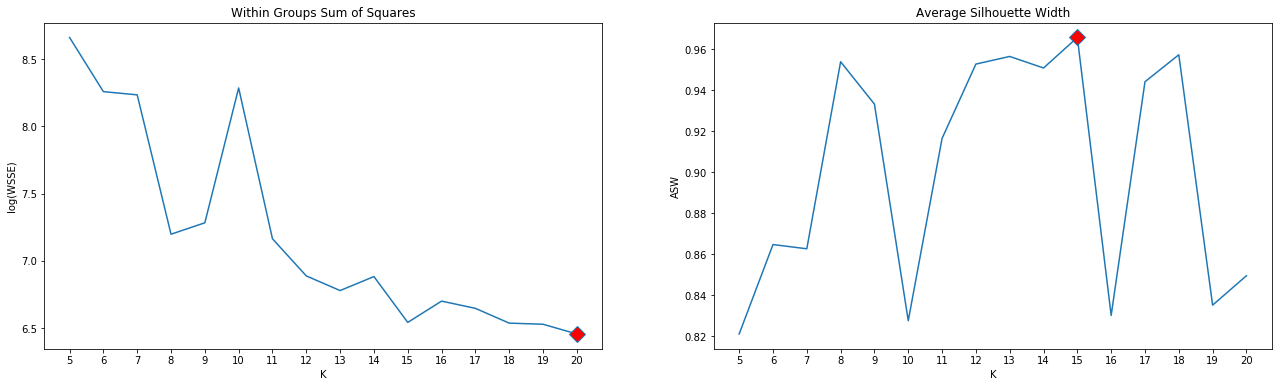

In [16]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(22,6))

best_K_wsse = np.argmin(wsse)
best_K_silhouette = np.argmax(silhouette)

_ = plt.subplot(1,2,1)
_ = plt.plot(k_list, np.log(wsse),'-D', markevery=[best_K_wsse], markerfacecolor='red', markersize=12)
# _ = plt.Circle(xy=(16,16257), radius=3, color="red")
_ = plt.xlabel("K")
_ = plt.ylabel("log(WSSE)")
_ = plt.xticks(k_list)
_ = plt.title("Within Groups Sum of Squares")

_ = plt.subplot(1,2,2)
_ = plt.plot(k_list, silhouette,'-D', markevery=[best_K_silhouette], markerfacecolor='red', markersize=12)
_ = plt.xlabel("K")
_ = plt.ylabel("ASW")
_ = plt.xticks(k_list)
_ = plt.title("Average Silhouette Width")
plt.show()

#### Posterior checks 

In [113]:
# from pyspark.ml.clustering import KMeansModel

# clustering_model = []
# for k in [4,8,12]:
#     clustering_model.append(KMeansModel.load("kmeans_k{}_trained".format(k)))

In [17]:
import numpy as np

for model in clustering_model:
    print("\n\nkmeans: K = {}".format(model.summary.k))
    print("Maximum number of iterations: {}".format(model.summary.numIter))
    
    # sort cluster sizes
    ord_sizes = model.summary.clusterSizes
    ord_idx = list(np.argsort(model.summary.clusterSizes))
    ord_sizes.sort(reverse=True)
    ord_idx.reverse()
    print("Cluster sizes:")
    for el in zip(ord_idx, ord_sizes):
        print("{}".format(el))



kmeans: K = 5
Maximum number of iterations: 4
Cluster sizes:
(1, 77740)
(2, 52991)
(0, 17325)
(3, 16709)
(4, 9155)


kmeans: K = 6
Maximum number of iterations: 2
Cluster sizes:
(1, 77714)
(0, 36191)
(5, 21462)
(2, 17311)
(3, 16214)
(4, 5028)


kmeans: K = 7
Maximum number of iterations: 2
Cluster sizes:
(1, 76324)
(0, 36190)
(5, 21432)
(2, 17311)
(3, 16214)
(4, 5028)
(6, 1421)


kmeans: K = 8
Maximum number of iterations: 5
Cluster sizes:
(1, 77712)
(0, 31708)
(5, 20126)
(4, 17255)
(2, 16214)
(3, 5014)
(6, 4124)
(7, 1767)


kmeans: K = 9
Maximum number of iterations: 2
Cluster sizes:
(1, 77712)
(3, 32267)
(5, 21267)
(4, 17311)
(0, 16214)
(2, 4694)
(7, 3501)
(6, 629)
(8, 325)


kmeans: K = 10
Maximum number of iterations: 6
Cluster sizes:
(1, 77720)
(3, 52979)
(6, 17325)
(0, 16709)
(2, 2413)
(5, 2401)
(7, 2133)
(9, 1721)
(4, 324)
(8, 195)


kmeans: K = 11
Maximum number of iterations: 2
Cluster sizes:
(1, 76322)
(3, 32267)
(10, 21236)
(6, 17311)
(0, 16214)
(2, 2833)
(5, 2401)
(7, 186

In [18]:
import pyspark.sql.functions as F

for model in clustering_model:
    
    print("\n\nkmeans: K = {}".format(model.summary.k))

    grouped_pred = model.summary.predictions.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("stop_token_1").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)



kmeans: K = 5
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |77740        |
|2         |52989        |
|0         |17325        |
|3         |16709        |
|4         |9155         |
+----------+-------------+



kmeans: K = 6
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |77714        |
|0         |36190        |
|5         |21461        |
|2         |17311        |
|3         |16214        |
|4         |5028         |
+----------+-------------+



kmeans: K = 7
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |76324        |
|0         |36189        |
|5         |21431        |
|2         |17311        |
|3         |16214        |
|4         |5028         |
|6         |1421         |
+----------+-------------+



kmeans: K = 8
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |77712        |
|0         |317

In [19]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def is_url(string):
    if string.find("://") != -1:
        return(True)
    return(False)
    

def is_ipv6(string):
    import numpy as np
    is_column = [1 if x==":" else 0 for x in string]
    if np.sum(is_column) >= 3 and string.find("/") == -1:
        return(True)
    return(False)

def is_address(string):
    import numpy as np
    is_column = [1 if x=="." else 0 for x in string]
    if np.sum(is_column) >= 2 and string.find("/") == -1:
        return(True)
    return(False)

def replace_address(string, replace_string=None):
    if not replace_string:
        if is_url(string):
            string = "$URL"
        elif is_ipv6(string):
            string = "$IPv6"
        elif is_address(string):
            string = "$ADDRESS"
    else:
        if is_url(string) or is_ipv6(string) or is_address(string):
            string = replace_string         
    return(string)


def abstract_address(tokens_list):
    '''Take a string and split url into netloc + path'''
    tks = [replace_address(x) for x in tokens_list]
    return(tks)

# transform in user defined function
abstract_address_udf = udf(abstract_address, StringType())

In [20]:
import pyspark.sql.functions as F

for model in clustering_model:
    print("\n\nkmeans: K = {}".format(model.summary.k))

    data_subset = model.summary.predictions
    data_subset = data_subset.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))

    grouped_pred = data_subset.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("abstract_tokens").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)



kmeans: K = 5
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|0         |12016        |
|4         |4971         |
|2         |1048         |
|1         |46           |
|3         |18           |
+----------+-------------+



kmeans: K = 6
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|2         |12004        |
|4         |4891         |
|5         |614          |
|0         |543          |
|1         |41           |
|3         |8            |
+----------+-------------+



kmeans: K = 7
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|2         |12004        |
|4         |4891         |
|5         |604          |
|0         |543          |
|1         |28           |
|6         |23           |
|3         |8            |
+----------+-------------+



kmeans: K = 8
+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|4         |11948        |
|3         |488

#### Best K 

In [14]:
%%time

import time
import datetime

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

# kmeans_models = []
# clustering_model = []


k_best = 12 # k_list.index(8)


start_time = time.time()
start_time_string = datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print("Started at: {}\n".format(start_time_string))
    
# for i, k in enumerate([k_best]):
kmeans_models_best = KMeans(featuresCol='features',k=k_best, initMode='k-means||',
                            initSteps=100, tol=0.000001, maxIter=50, distanceMeasure='cosine')
clustering_model_best = kmeans_models_best.fit(train_data)

# compute metrics   \
wsse_best = clustering_model_best.summary.trainingCost
silhouette_best = evaluator.evaluate(clustering_model_best.summary.predictions)

print("With K={}".format(k_best))
print("Within Cluster Sum of Squared Errors = " + str(wsse_best))
print("Silhouette with cosine distance = " + str(silhouette_best))

print("\nTime elapsed: {} minutes and {} seconds.".format(int((time.time() - start_time)/60),
                                                          int((time.time() - start_time)%60)))
    
print('--'*30)

Started at: 2019-11-28 08:09:53

With K=12
Within Cluster Sum of Squared Errors = 1016.6770720753077
Silhouette with cosine distance = 0.9445094195274792

Time elapsed: 6 minutes and 50 seconds.
------------------------------------------------------------
CPU times: user 3.73 s, sys: 2.4 s, total: 6.12 s
Wall time: 6min 50s


##### Save best model 

In [124]:
clustering_model_best.write().overwrite().save("kmeans_k12_best.model")
data_subset = clustering_model_best.summary.predictions
data_subset.write.json("kmeans_k12_best.json", mode="overwrite")

#### Clusters' sizes (already unique messages)

In [87]:
import numpy as np

# for clustering_model_best in [clustering_clustering_model_best_best]:
print("\n\nkmeans: K = {}".format(clustering_model_best.summary.k))
print("Maximum number of iterations: {}".format(clustering_model_best.summary.numIter))

# sort cluster sizes
ord_sizes = clustering_model_best.summary.clusterSizes
ord_idx = list(np.argsort(clustering_model_best.summary.clusterSizes))
ord_sizes.sort(reverse=True)
ord_idx.reverse()

print("\n\nCluster sizes:")
for el in zip(ord_idx, ord_sizes):
    print("{}".format(el))



kmeans: K = 12
Maximum number of iterations: 10


Cluster sizes:
(1, 77697)
(0, 30722)
(4, 20122)
(3, 17255)
(5, 16214)
(2, 4546)
(9, 3500)
(8, 1752)
(11, 1003)
(6, 623)
(10, 323)
(7, 163)


#### Clusters' unique messages after abstraction 

In [16]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType

def is_url(string):
    if string.find("://") != -1:
        return(True)
    return(False)
    

def is_ipv6(string):
    import numpy as np
    is_column = [1 if x==":" else 0 for x in string]
    if np.sum(is_column) >= 3 and string.find("/") == -1:
        return(True)
    return(False)

def is_address(string):
    import numpy as np
    is_point = [1 if x=="." else 0 for x in string]
    if np.sum(is_point) >= 2 and string.find("/") == -1:
        return(True)
    return(False)

def is_path(string):
    if string.startswith("path="):
        return(True)
    return(False)

def is_file_path(string):
    if string.startswith("/") and all(char in string[1:] for char in [".", "/"]):
        return(True)
    return(False)

def is_net_param(string):
    if string.startswith("[net="):
        return(True)
    return(False)

def is_filesize_mismatch(string):
    if string.startswith("(expected="):
        res = "$EXPECTED_SIZE"
    elif string.startswith("actual="):
        res = "$ACTUAL_SIZE"
    else:
        res = False
    return(res)

def is_remote_entity(string):
    if string.startswith("(/cn="):
        res = "$EXPECTED_REMOTE_ENTITY"
    elif string.startswith("(/dc="):
        res = "$ACTUAL_REMOTE_ENTITY"
    else:
        res = False
    return(res)
    
def replace_address(string, replace_string=None):
    if not replace_string:
        if is_url(string):
            string = "$URL"
        elif is_ipv6(string):
            string = "$IPv6"
        elif is_address(string):
            string = "$ADDRESS"
        elif is_path(string):
            string = "$PATH"
        elif is_file_path(string):
            string = "$FILE_PATH"
        elif is_net_param(string):
            string = "$NET_PARAM"
        elif is_filesize_mismatch(string):
            string = is_filesize_mismatch(string)
        elif is_remote_entity(string):
            string = is_remote_entity(string)
    else:
        if is_url(string) or is_ipv6(string) or is_address(string) or is_path(string):
            string = replace_string
    return(string)

def replace_IDS(tokens_list, ID_precursors=["transaction", "process", "message", "relation", "database", "tuple"]):
    import re
    msg_pattern = re.compile("<[0-9]+:[0-9]+>")
    precursor_flags = [False]*len(ID_precursors)
    
    res = []
    for tkn in tokens_list:
        
        if True in precursor_flags:
            i = precursor_flags.index(True)
            if ID_precursors[i]=="message" and not msg_pattern.match(tkn):
                res.append(tkn)
                precursor_flags[i]=False
                next
            res.append("${}_ID".format(ID_precursors[i].upper()))
            precursor_flags[i]=False
        else:
            res.append(tkn)
        
        if tkn in ID_precursors:
            precursor_flags[ID_precursors.index(tkn)]=True
    return(res)

def abstract_message(tokens_list):
    '''Take a string and split url into netloc + path'''
    tks = [replace_address(x) for x in tokens_list]
    tks = replace_IDS(tks)
    return(tks)

# transform in user defined function
abstract_message_udf = udf(abstract_message, ArrayType(StringType()))

##### No path abstraction

In [89]:
import pyspark.sql.functions as F

data_subset_no_abs = clustering_model_best.summary.predictions
data_subset_no_abs = data_subset_no_abs.withColumn("abstract_tokens", abstract_message_udf("stop_token_1"))

grouped_pred1 = data_subset_no_abs.groupBy("prediction")
grouped_pred_agg1 = grouped_pred1.agg(F.countDistinct("t__error_message").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False)
grouped_pred_agg1.withColumnRenamed("prediction", "cluster_label").show(truncate=False)
# agg_summary1 = grouped_pred_agg1.toPandas()

+-------------+-------------+
|cluster_label|n_unique_mess|
+-------------+-------------+
|1            |77697        |
|0            |30722        |
|4            |20122        |
|3            |17255        |
|5            |16214        |
|2            |4546         |
|9            |3500         |
|8            |1752         |
|11           |1003         |
|6            |623          |
|10           |323          |
|7            |163          |
+-------------+-------------+



##### With path abstraction 

In [17]:
import pyspark.sql.functions as F

data_subset = clustering_model_best.summary.predictions
data_subset = data_subset.withColumn("abstract_tokens", abstract_message_udf("stop_token_1")).dropDuplicates(['abstract_tokens'])
data_subset.cache()
grouped_pred = data_subset.groupBy("prediction")
grouped_pred_agg = grouped_pred.agg(F.countDistinct("abstract_tokens").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False)
grouped_pred_agg.show(truncate=False)
agg_summary = grouped_pred_agg.toPandas()

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|8         |123          |
|3         |74           |
|0         |65           |
|2         |62           |
|4         |60           |
|9         |52           |
|11        |49           |
|7         |31           |
|1         |24           |
|10        |16           |
|6         |12           |
|5         |8            |
+----------+-------------+



#### All clusters


In [23]:
import pandas as pd
from termcolor import colored

pd.set_option('display.max_colwidth', -1)

big_cluster_threshold = 1
clust_ids = list(agg_summary.prediction[agg_summary.n_unique_mess >=big_cluster_threshold])

# data_subset = clustering_model_best.summary.predictions.withColumn("abstract_tokens", abstract_message_udf("stop_token_1")).dropDuplicates(['abstract_tokens'])

# clust_ids.reverse()

n_mess_to_show = 10
for idx, clust_id in enumerate(clust_ids):

    print( colored("Cluster n.{}".format(clust_id), 'red'))
    
    perc = min(n_mess_to_show/agg_summary.n_unique_mess[idx],1.)
    cluster = data_subset.filter("prediction == {}".format(clust_id)).sample(withReplacement=False, fraction=perc)

    # In case of pyspark dataframe format for cluster
#     nrows = agg_summary.n_unique_mess[agg_summary.prediction==clust_id].values[0]
#     cluster_unique_messages.show(n=int(nrows), truncate=False)
    
    # In case of pandas dataframe format for cluster
    cluster_unique_messages = cluster.select("t__error_message", "abstract_tokens").toPandas()
    for idx, row in enumerate(cluster_unique_messages.values):
        print( colored("Row_id: {}.".format(idx), 'blue'))
        print("Message:\n", row[0], "\n")
        print("Abstraction:\n", row[1], "\n\n")

Cluster n.8
Row_id: 0.
Message:
 globus_xio: Unable to connect to gridftp.echo.stfc.ac.uk:2811 globus_xio: globus_libc_getaddrinfo failed. globus_common: Temporary failure in name resolution 

Abstraction:
 ['globus_xio', 'unable', 'connect', '$ADDRESS', 'globus_xio', 'globus_libc_getaddrinfo', 'failed', 'globus_common', 'temporary', 'failure', 'name', 'resolution'] 


Row_id: 1.
Message:
 globus_ftp_client: the server responded with an error 500 Command failed : Internal server error 

Abstraction:
 ['globus_ftp_client', 'server', 'responded', 'error', '500', 'command', 'failed', 'internal', 'server', 'error'] 


Row_id: 2.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio: Unable to connect to 130.246.176.235:50266  500-globus_xio: globus_xio_system_socket_register_connect failed.  500-globus_xio: System error in connect: Network is unreachable  500-globus_xio: A system call failed: Network is unreachable  500 End. 

Abstra

Row_id: 0.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio: The GSI XIO driver failed to establish a connection via the underlying protocol.  500-globus_xio: Unable to connect to storage053.ppgrid1.rhul.ac.uk:2811  500-globus_xio: System error in connect: Connection refused  500-globus_xio: A system call failed: Connection refused  500 End. 

Abstraction:
 ['transfer', 'globus_ftp_client', 'server', 'responded', 'error', '500', '500', 'command', 'failed', 'globus_xio', 'gsi', 'xio', 'driver', 'failed', 'establish', 'connection', 'via', 'underlying', 'protocol', '500', 'globus_xio', 'unable', 'connect', '$ADDRESS', '500', 'globus_xio', 'system', 'error', 'connect', 'connection', 'refused', '500', 'globus_xio', 'system', 'call', 'failed', 'connection', 'refused', '500', 'end'] 


Row_id: 1.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio_tcp_driver.c:globus_l_xio_

Row_id: 0.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 451 Unable to reserve space: no linkgroups configured. 

Abstraction:
 ['transfer', 'globus_ftp_client', 'server', 'responded', 'error', '451', 'unable', 'reserve', 'space', 'linkgroups', 'configured'] 


Row_id: 1.
Message:
 globus_ftp_client: the server responded with an error 421 Service busy: Connection limit exceeded. Please try again later. Closing control connection. 

Abstraction:
 ['globus_ftp_client', 'server', 'responded', 'error', '421', 'service', 'busy', 'connection', 'limit', 'exceeded', 'please', 'try', 'later', 'closing', 'control', 'connection'] 


Row_id: 2.
Message:
 TRANSFER  globus_l_ftp_control_read_cb: Error while searching for end of reply 

Abstraction:
 ['transfer', 'globus_l_ftp_control_read_cb', 'error', 'searching', 'end', 'reply'] 


Row_id: 3.
Message:
 SOURCE CHECKSUM globus_ftp_client: the server responded with an error 504 Unsupported checksum type:java.lang.IllegalAr

Row_id: 0.
Message:
 DESTINATION SRM_PUT_TURL error on the turl  request : [SE][StatusOfPutRequest][SRM_INTERNAL_ERROR] error accessing dpms31.indiacms.res.in:/disk02/cms/2019-10-09: Timed out 

Abstraction:
 ['destination', 'srm_put_turl', 'error', 'turl', 'request', '[se][statusofputrequest][srm_internal_error]', 'error', 'accessing', 'dpms31.indiacms.res.in:/disk02/cms/2019-10-09', 'timed'] 


Row_id: 1.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 530 Login failed: Request to [>gplazma-vorolemap@local] timed out. 

Abstraction:
 ['transfer', 'globus_ftp_client', 'server', 'responded', 'error', '530', 'login', 'failed', 'request', '[>gplazma-vorolemap@local]', 'timed'] 


Row_id: 2.
Message:
 SOURCE CHECKSUM an end-of-file was reached globus_xio: An end of file occurred 

Abstraction:
 ['source', 'checksum', 'end-of-file', 'reached', 'globus_xio', 'end', 'file', 'occurred'] 


Row_id: 3.
Message:
 Error reported from srm_ifce : 70 [SE][Ls][SRM_INTERNAL_E

Row_id: 0.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 451 General problem: Problem while connected to [2401:de00:2:33::27]:22582: 

Abstraction:
 ['transfer', 'globus_ftp_client', 'server', 'responded', 'error', '451', 'general', 'problem', 'problem', 'connected', '$IPv6'] 


Row_id: 1.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 451 General problem: Problem while connected to 10.42.38.51:46674: Connection reset by peer 

Abstraction:
 ['transfer', 'globus_ftp_client', 'server', 'responded', 'error', '451', 'general', 'problem', 'problem', 'connected', '$ADDRESS', 'connection', 'reset', 'peer'] 


Row_id: 2.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 451 General problem: Problem while connected to 129.107.255.8:57653: Network is unreachable 

Abstraction:
 ['transfer', 'globus_ftp_client', 'server', 'responded', 'error', '451', 'general', 'problem', 'problem', 'connected', '$ADDRESS', 'network',

Row_id: 0.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 451 General problem: Problem while connected to [2001:630:58:1c20::82f6:2fba]:50513: La m  quina remota ha reiniciat la connexi 

Abstraction:
 ['transfer', 'globus_ftp_client', 'server', 'responded', 'error', '451', 'general', 'problem', 'problem', 'connected', '$IPv6', 'la', 'm', 'quina', 'remota', 'ha', 'reiniciat', 'la', 'connexi'] 


Row_id: 1.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 451 General problem: Problem while connected to 193.205.76.72:24895: La connexi   ha expirat 

Abstraction:
 ['transfer', 'globus_ftp_client', 'server', 'responded', 'error', '451', 'general', 'problem', 'problem', 'connected', '$ADDRESS', 'la', 'connexi', 'ha', 'expirat'] 


Row_id: 2.
Message:
 TRANSFER  globus_ftp_client: the server responded with an error 451 General problem: Problem while connected to 129.107.255.8:56718: La m  quina remota ha reiniciat la connexi 

Abstraction:


## Visualisation 

In [18]:
# data_subset = clustering_model_best.summary.predictions.withColumn("abstract_tokens", abstract_message_udf("stop_token_1")).dropDuplicates(['abstract_tokens'])

In [18]:
data_subset.columns

['msg_id',
 't__error_message',
 'stop_token_1',
 'message_vector',
 'features',
 'prediction',
 'abstract_tokens']

In [19]:
import pandas as pd
from termcolor import colored

pd.set_option('display.max_colwidth', -1)

# big_cluster_threshold = 1
clust_ids = list(agg_summary.prediction)

# data_subset = clustering_model_best.summary.predictions.withColumn("abstract_tokens", abstract_message_udf("stop_token_1")).dropDuplicates(['abstract_tokens'])

# clust_ids.reverse()
cluster_documents = []
for idx, clust_id in enumerate(clust_ids):
    cluster = data_subset.filter("prediction == {}".format(clust_id))
    cluster_document = []
    for mess in cluster.select("abstract_tokens").collect():
        cluster_document.extend(mess[0])
    cluster_documents.append(cluster_document)
    
agg_summary["cluster_tokens"] = cluster_documents
grouped_pred_agg = spark.createDataFrame(agg_summary)
grouped_pred_agg.cache()
grouped_pred_agg.show()

+----------+-------------+--------------------+
|prediction|n_unique_mess|      cluster_tokens|
+----------+-------------+--------------------+
|         8|          123|[transfer, globus...|
|         3|           74|[source, checksum...|
|         0|           65|[transfer, globus...|
|         2|           62|[destination, srm...|
|         4|           60|[transfer, globus...|
|         9|           52|[destination, che...|
|        11|           49|[source, checksum...|
|         7|           31|[srm-ifce, err, c...|
|         1|           24|[transfer, globus...|
|        10|           16|[destination, ove...|
|         6|           12|[destination, srm...|
|         5|            8|[transfer, globus...|
+----------+-------------+--------------------+



In [38]:
from pyspark.ml.feature import CountVectorizer, IDF

# count frequency of each token in each text (bag of words model)
count_vec = CountVectorizer(inputCol="cluster_tokens", outputCol="token_freq")
count_vec_model = count_vec.fit(grouped_pred_agg)
tks_freq = count_vec_model.transform(grouped_pred_agg)
idf = IDF(inputCol="token_freq", outputCol="tf_idf")
tks_freq = idf.fit(tks_freq).transform(tks_freq)
tks_freq.cache()
tks_freq.show()

+----------+-------------+--------------------+--------------------+--------------------+
|prediction|n_unique_mess|      cluster_tokens|          token_freq|              tf_idf|
+----------+-------------+--------------------+--------------------+--------------------+
|         8|          123|[transfer, globus...|(707,[0,1,2,3,4,5...|(707,[0,1,2,3,4,5...|
|         3|           74|[source, checksum...|(707,[0,1,2,3,4,5...|(707,[0,1,2,3,4,5...|
|         0|           65|[transfer, globus...|(707,[0,1,3,4,5,6...|(707,[0,1,3,4,5,6...|
|         2|           62|[destination, srm...|(707,[0,2,3,4,5,6...|(707,[0,2,3,4,5,6...|
|         4|           60|[transfer, globus...|(707,[0,1,2,3,4,5...|(707,[0,1,2,3,4,5...|
|         9|           52|[destination, che...|(707,[0,3,8,9,10,...|(707,[0,3,8,9,10,...|
|        11|           49|[source, checksum...|(707,[0,1,2,3,4,5...|(707,[0,1,2,3,4,5...|
|         7|           31|[srm-ifce, err, c...|(707,[0,1,3,4,5,6...|(707,[0,1,3,4,5,6...|
|         

##### Save aggregate result 

In [126]:
tks_freq.write.json("cluster_tokens.json", mode="overwrite")

### TF-IDF

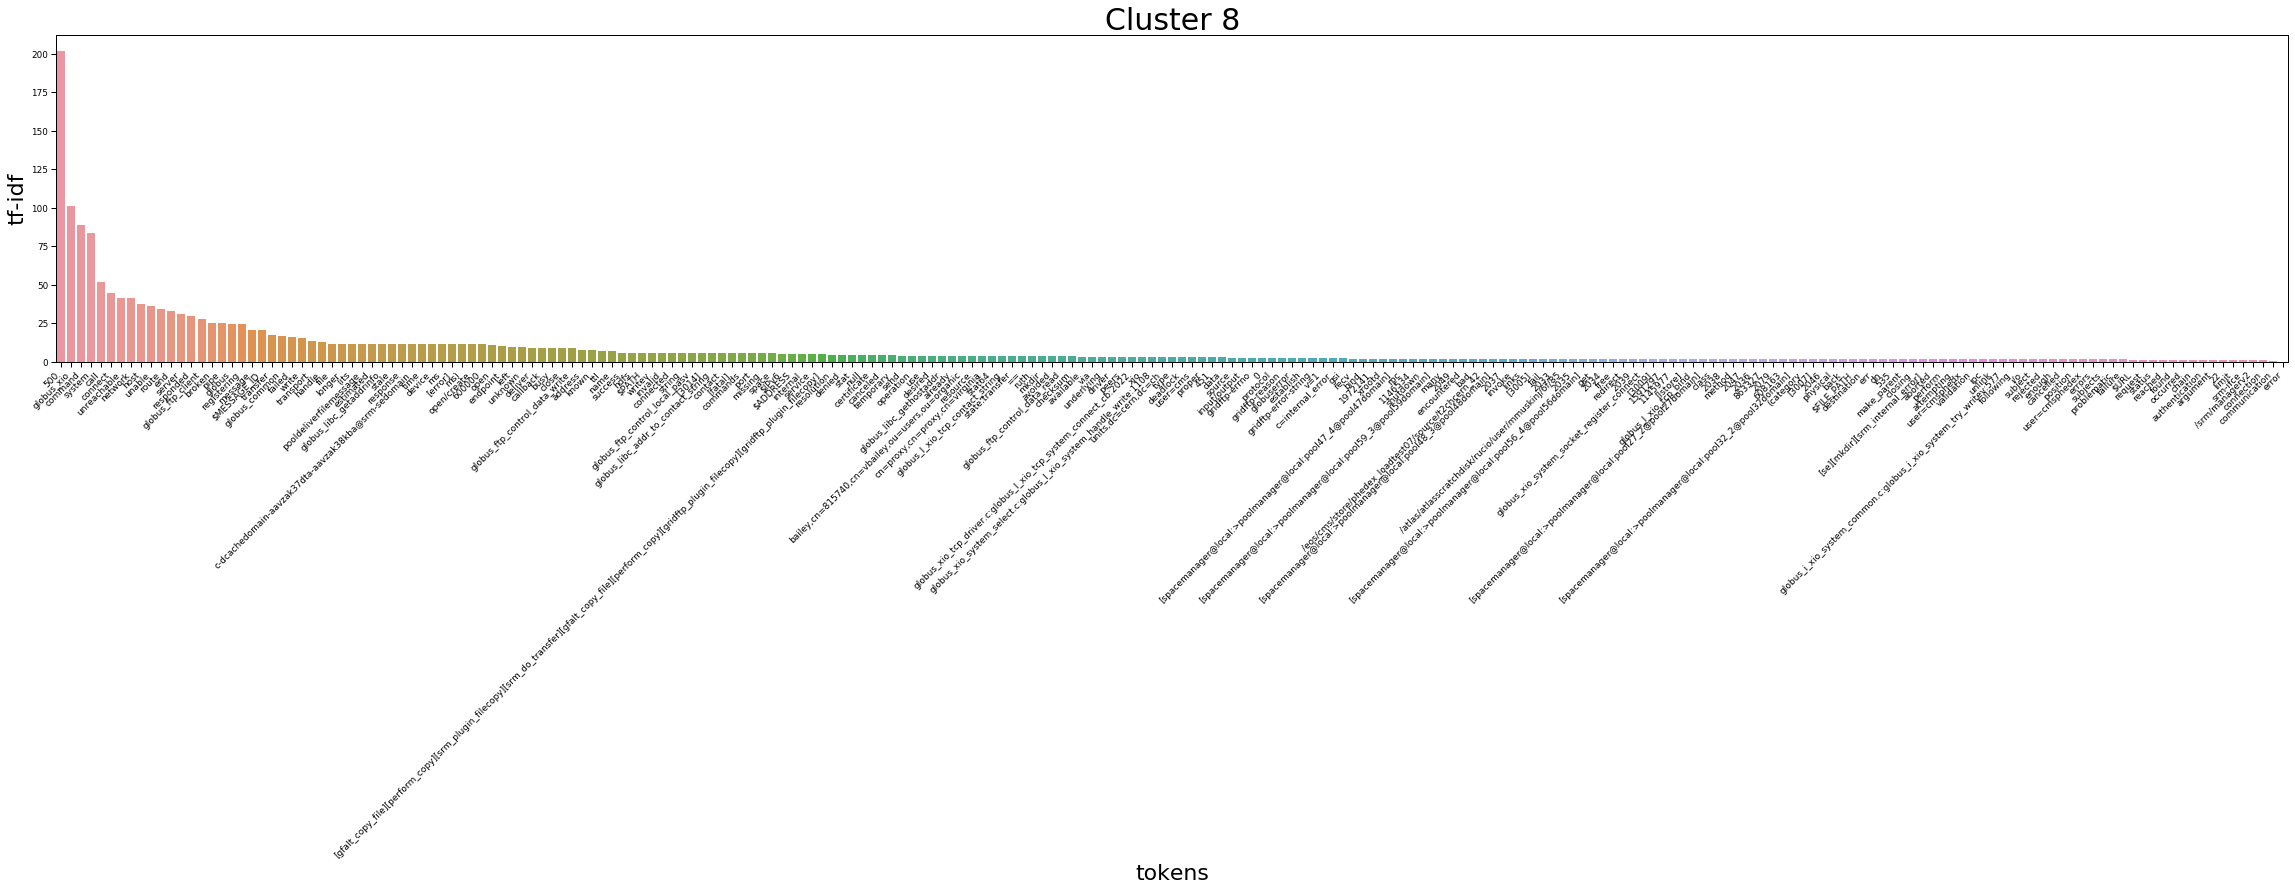

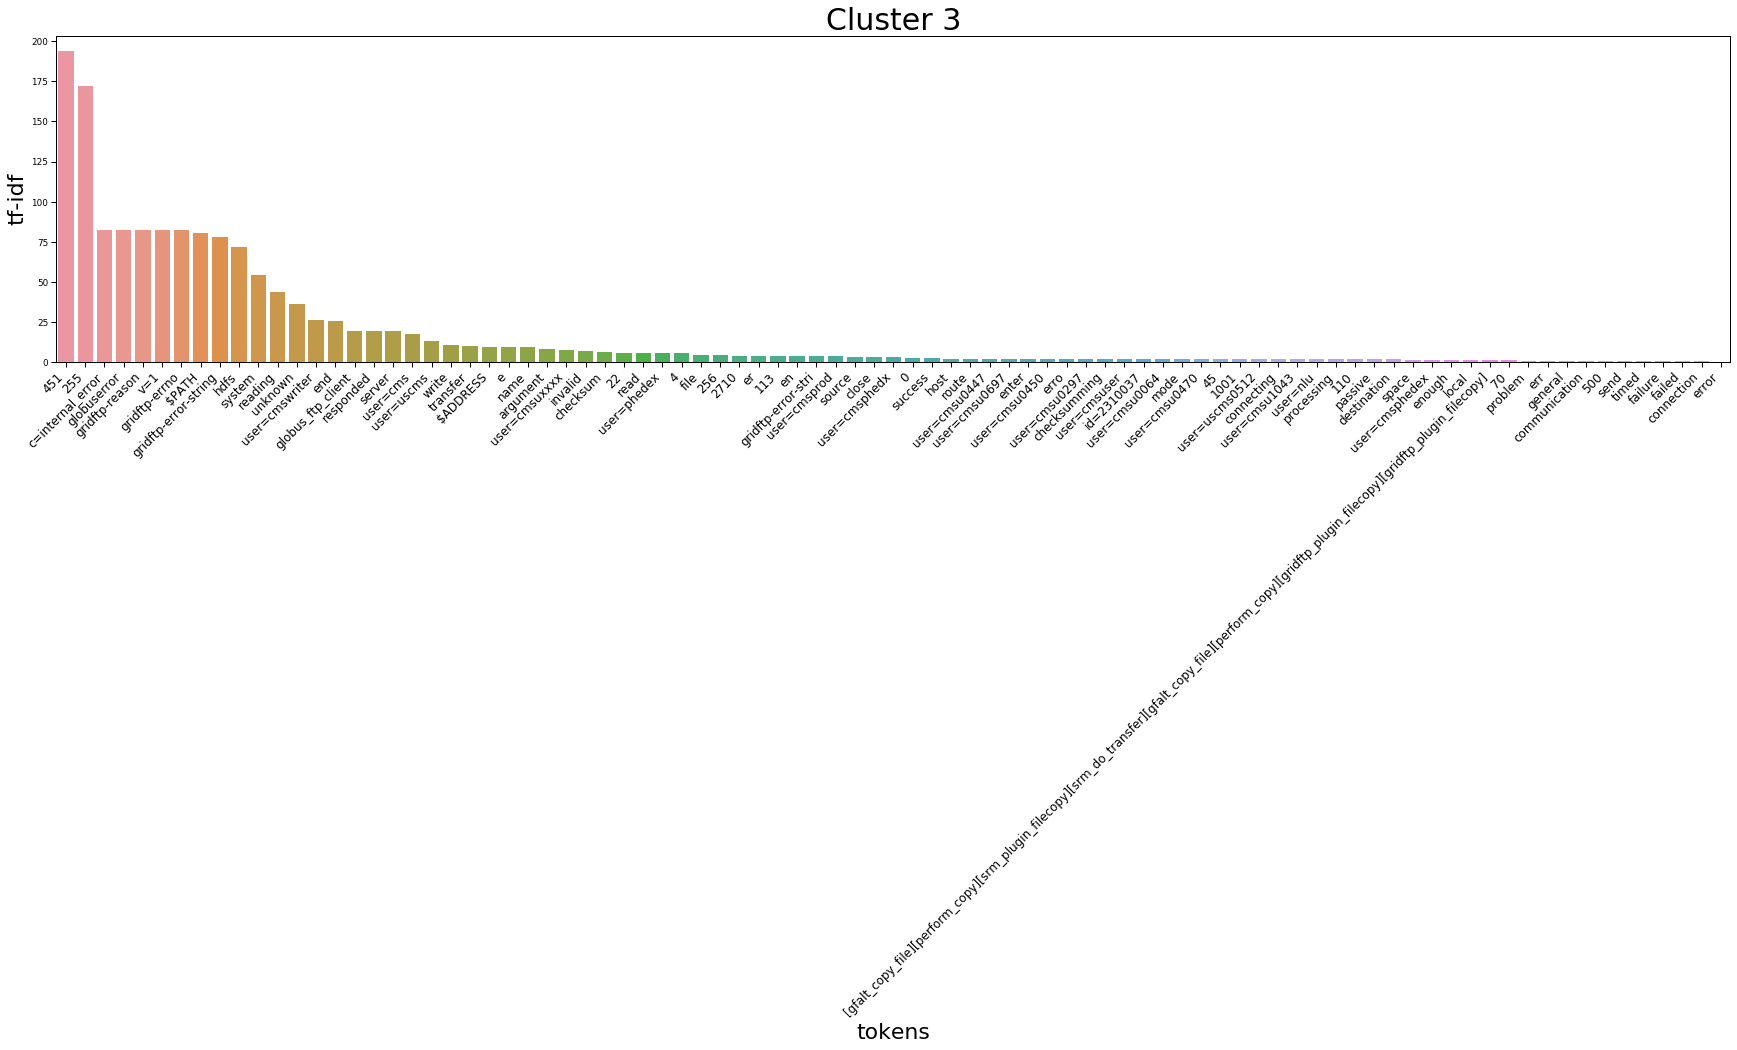

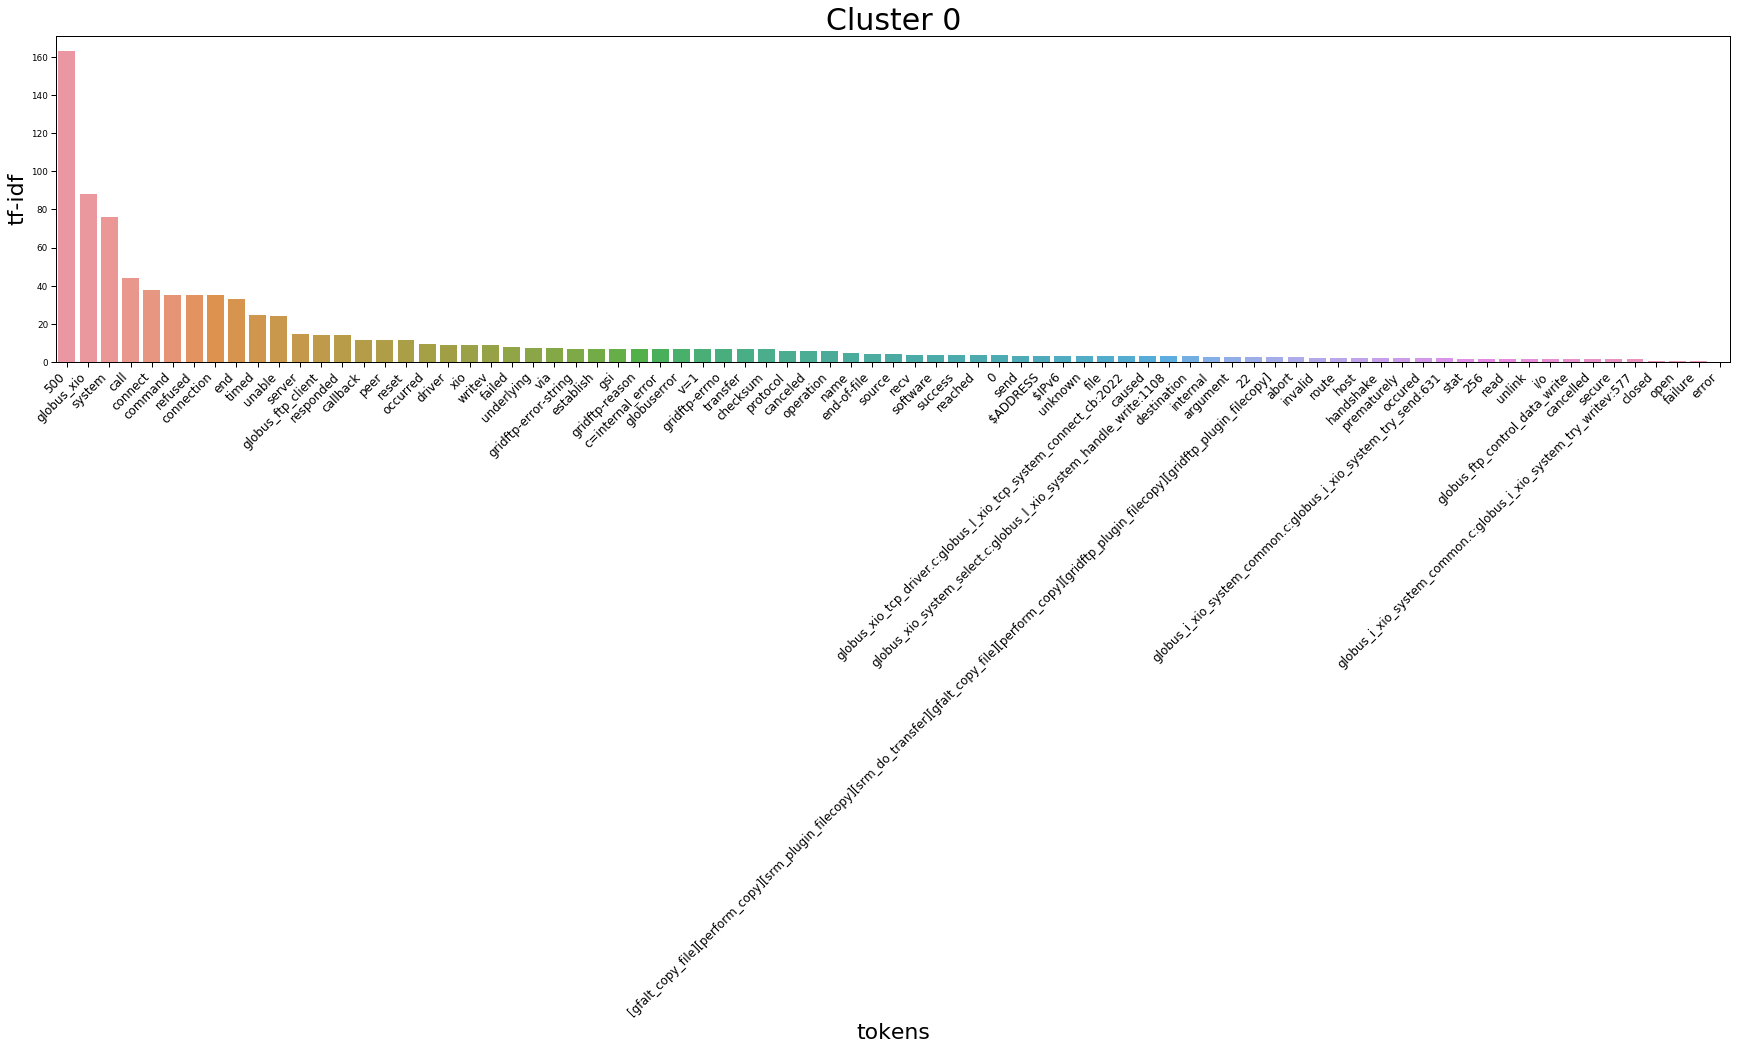

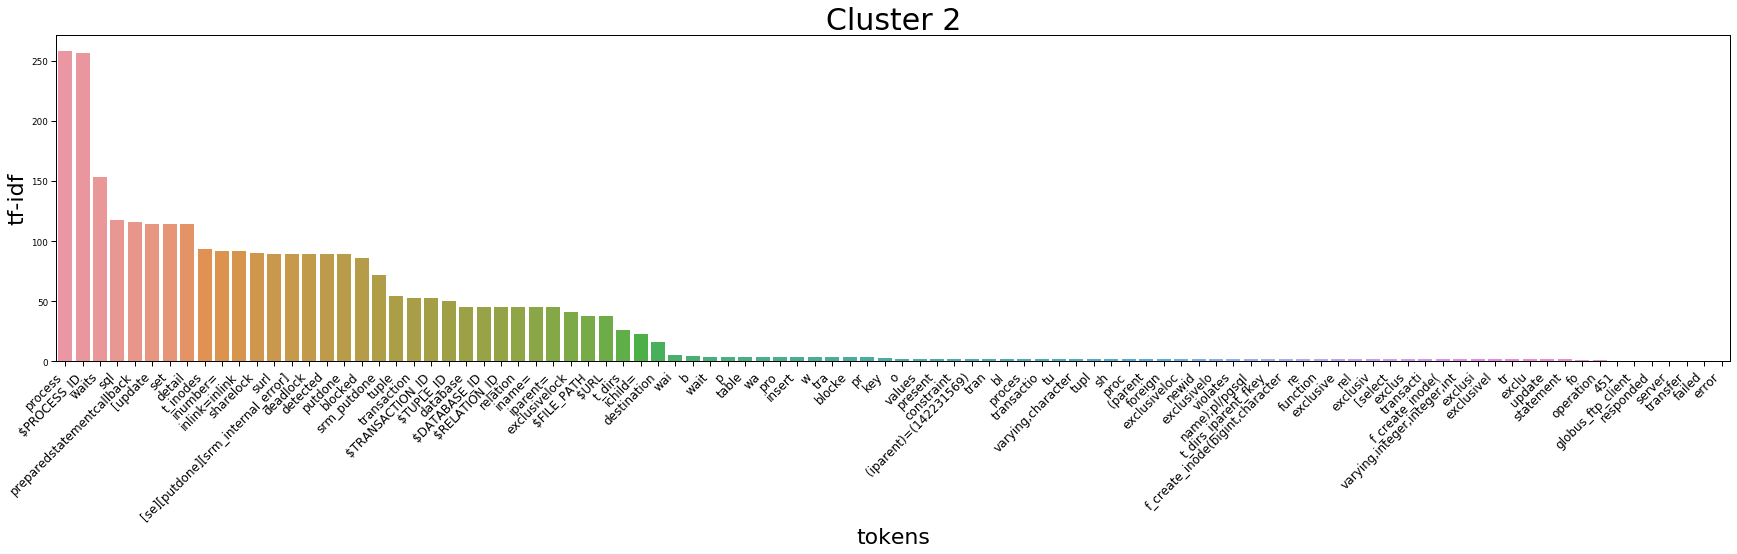

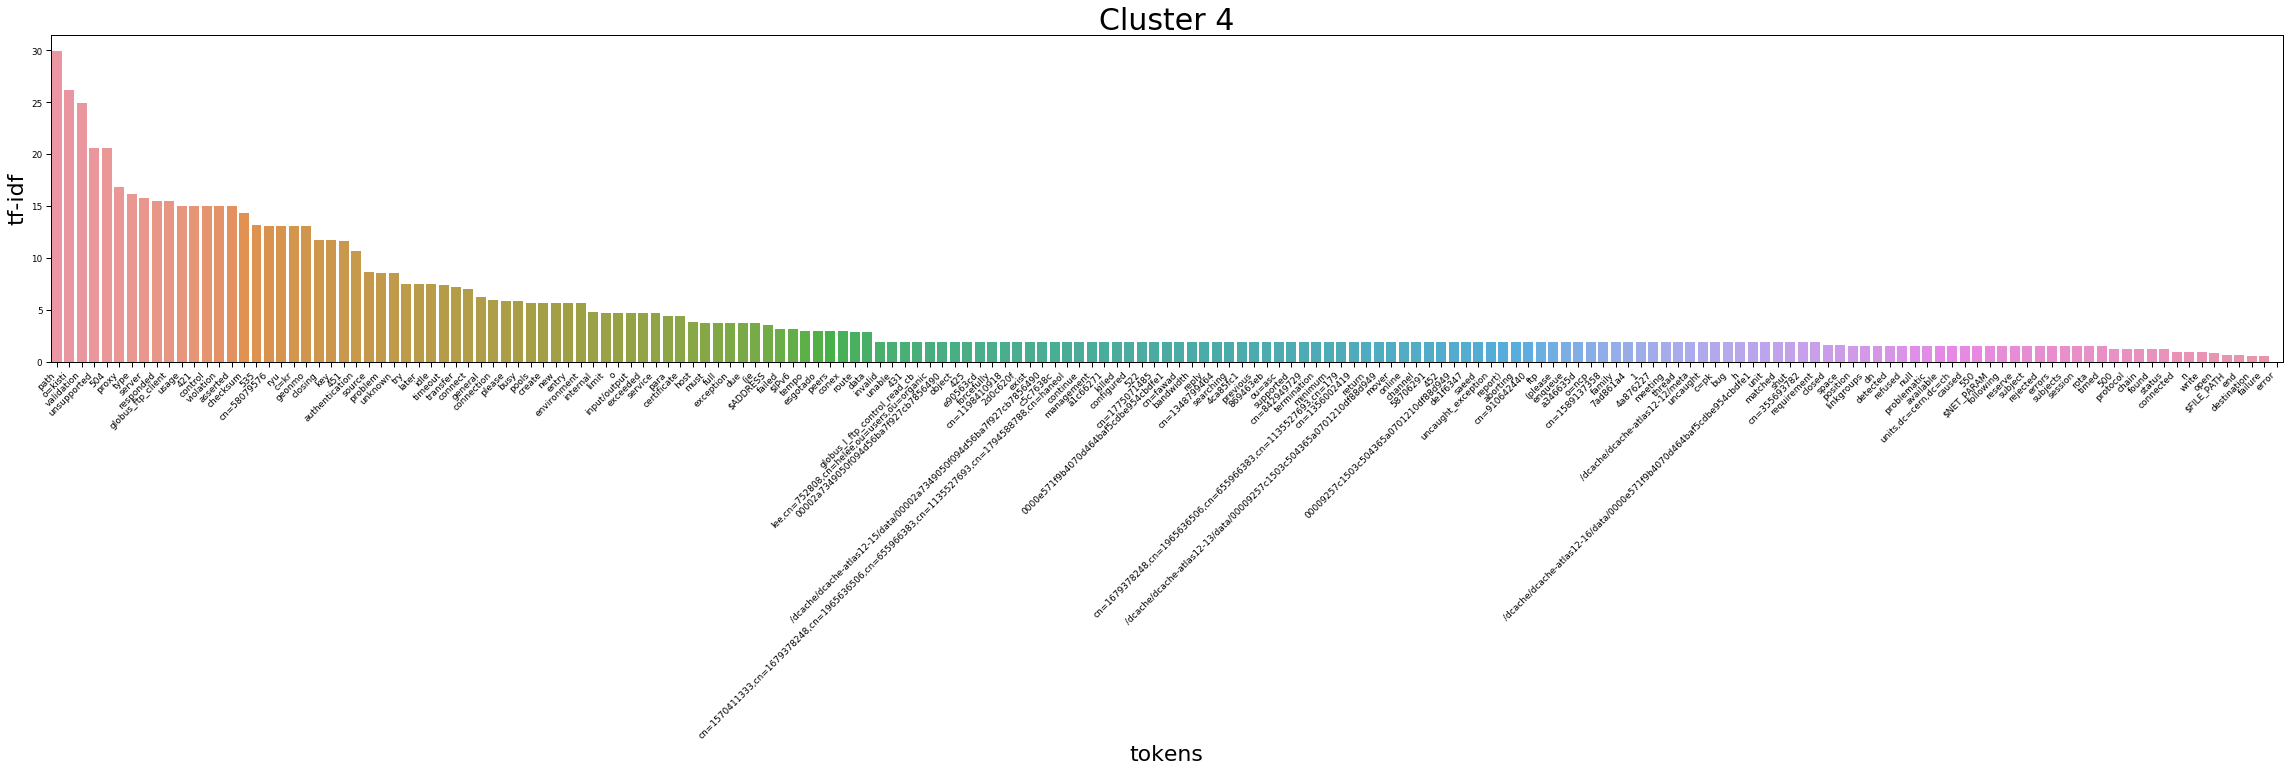

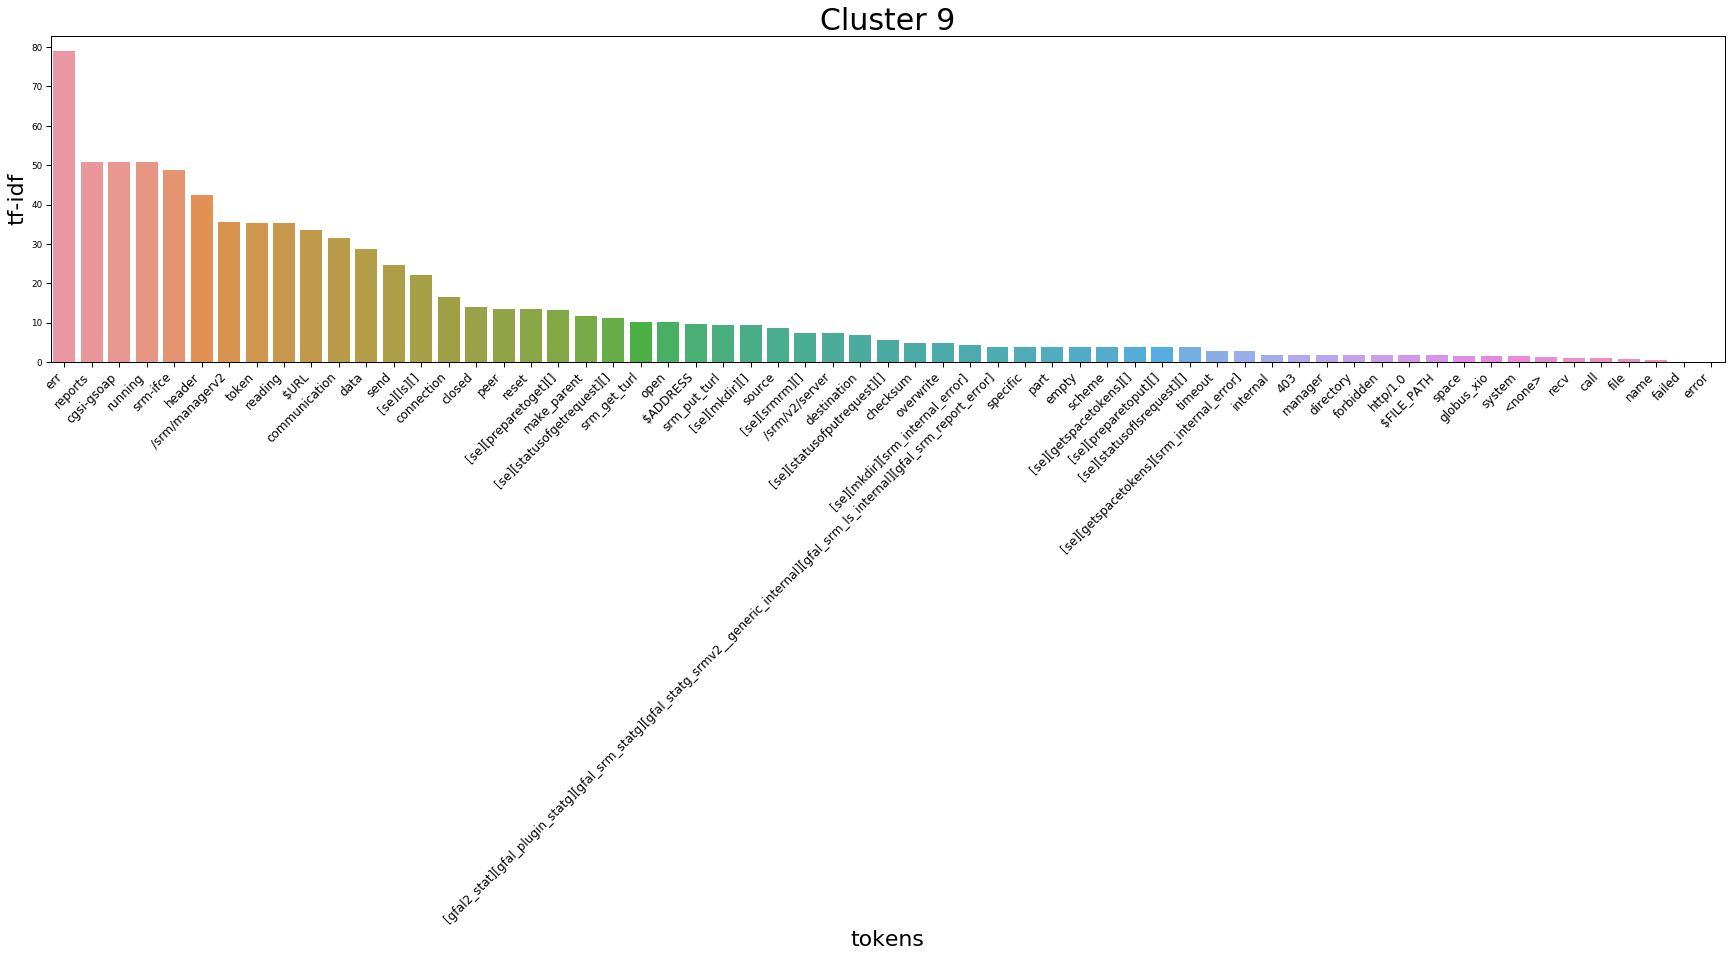

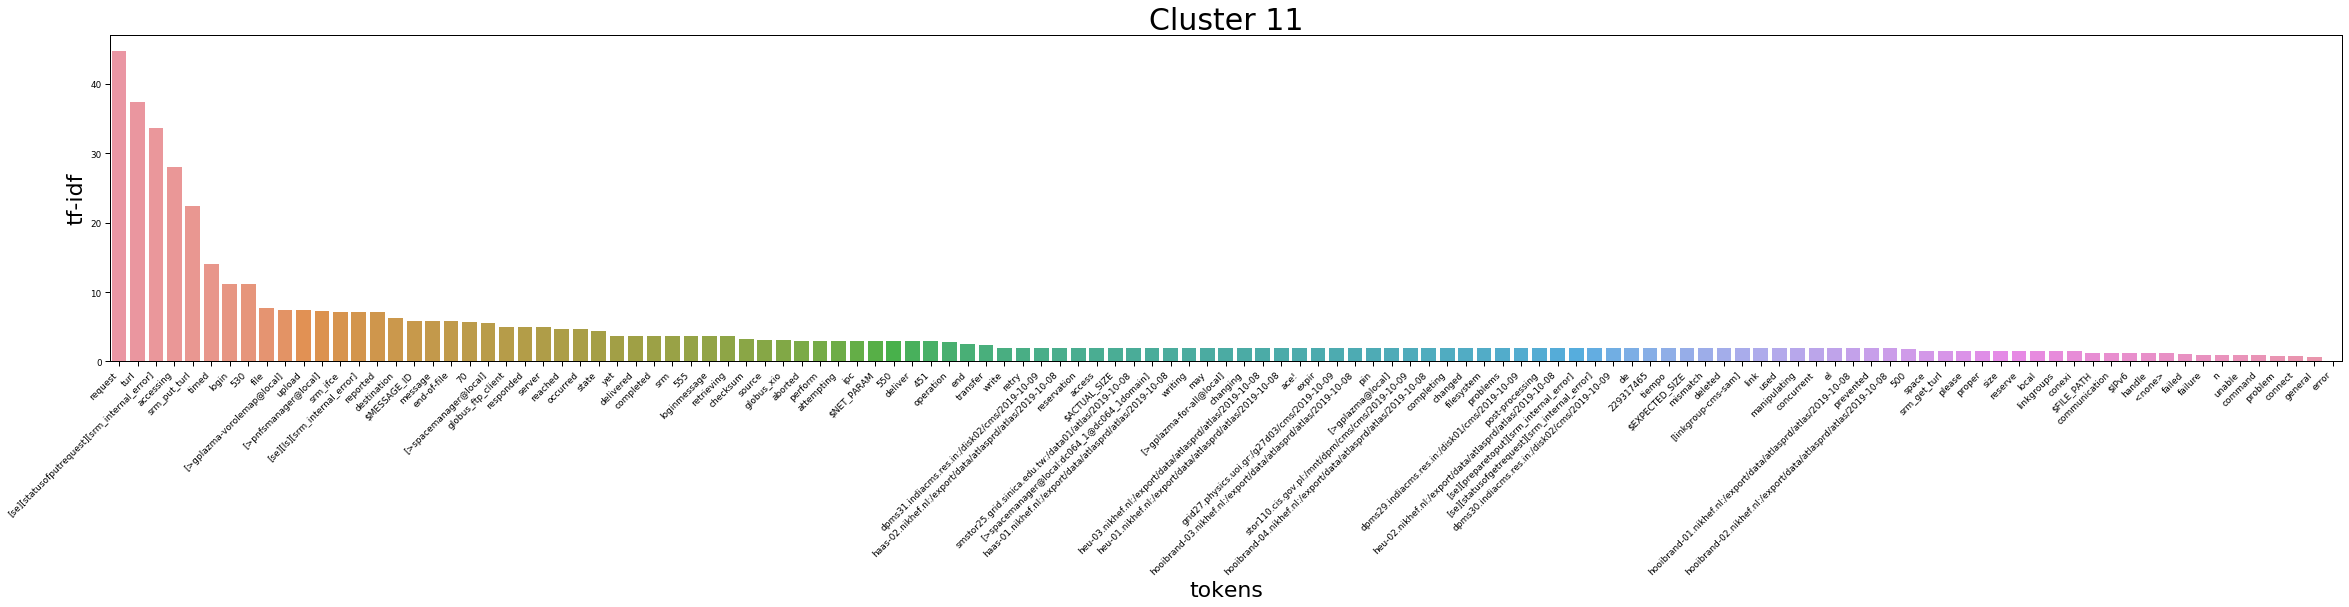

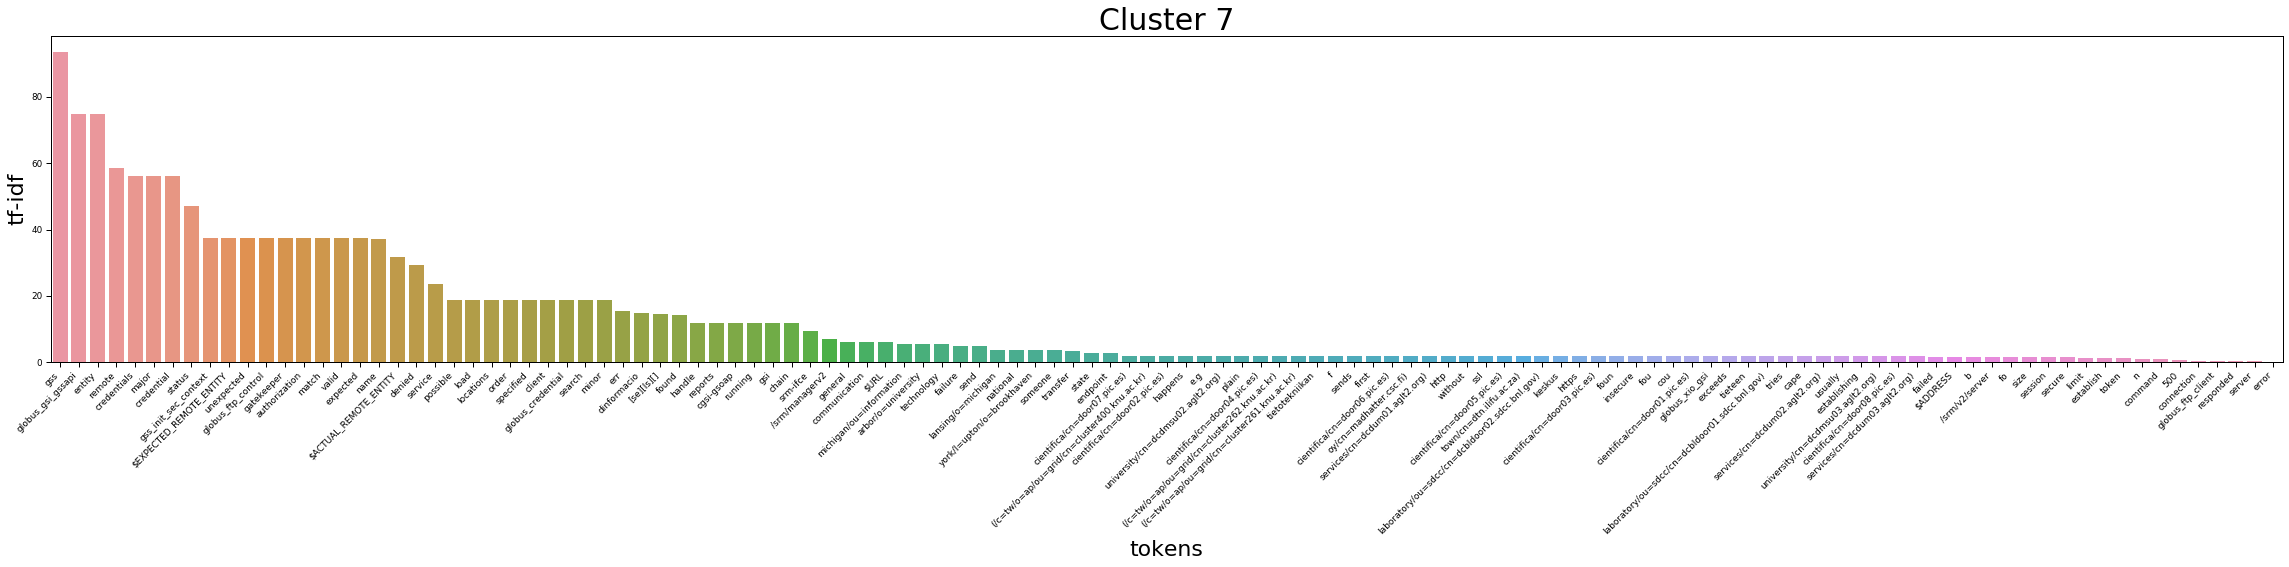

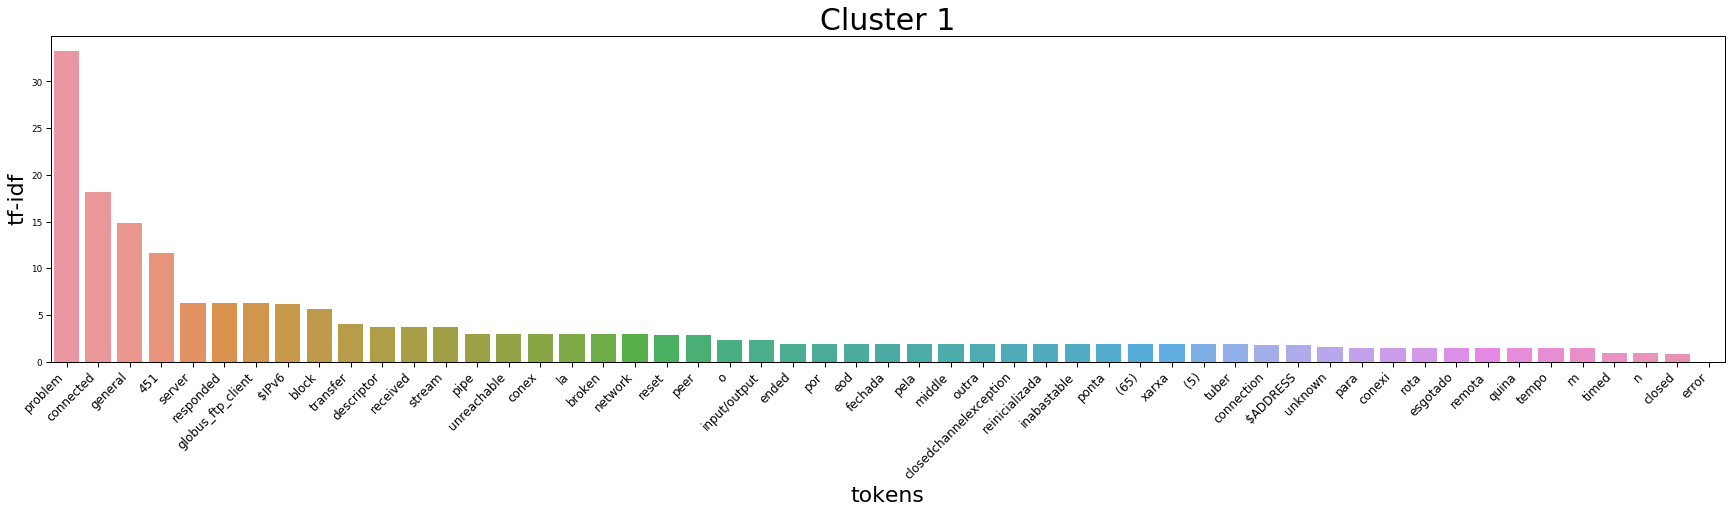

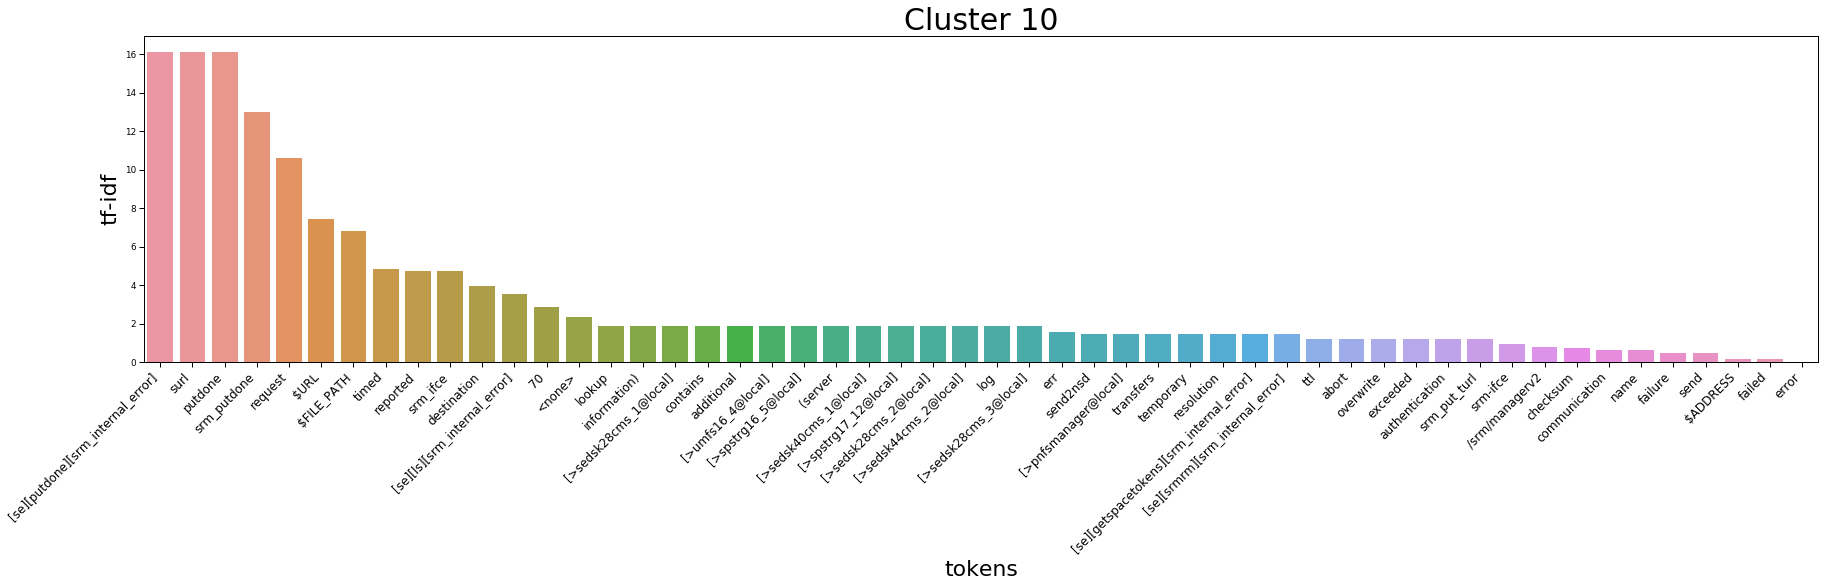

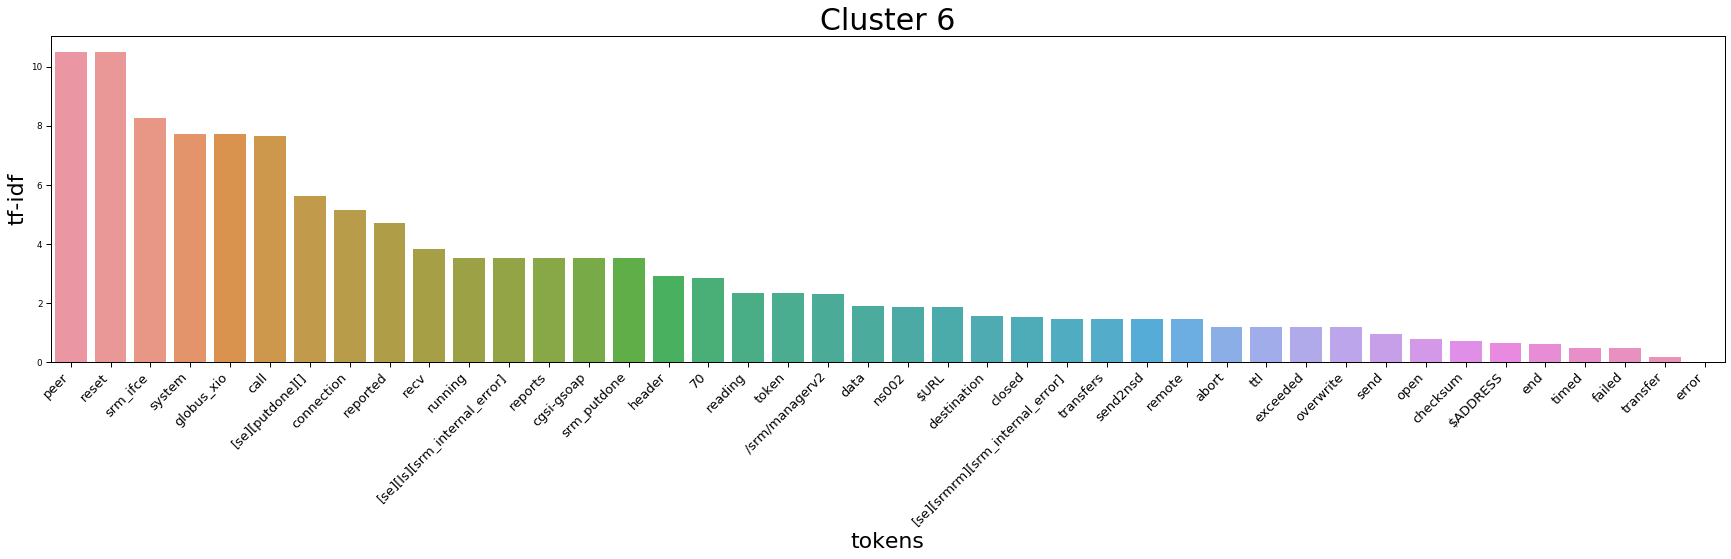

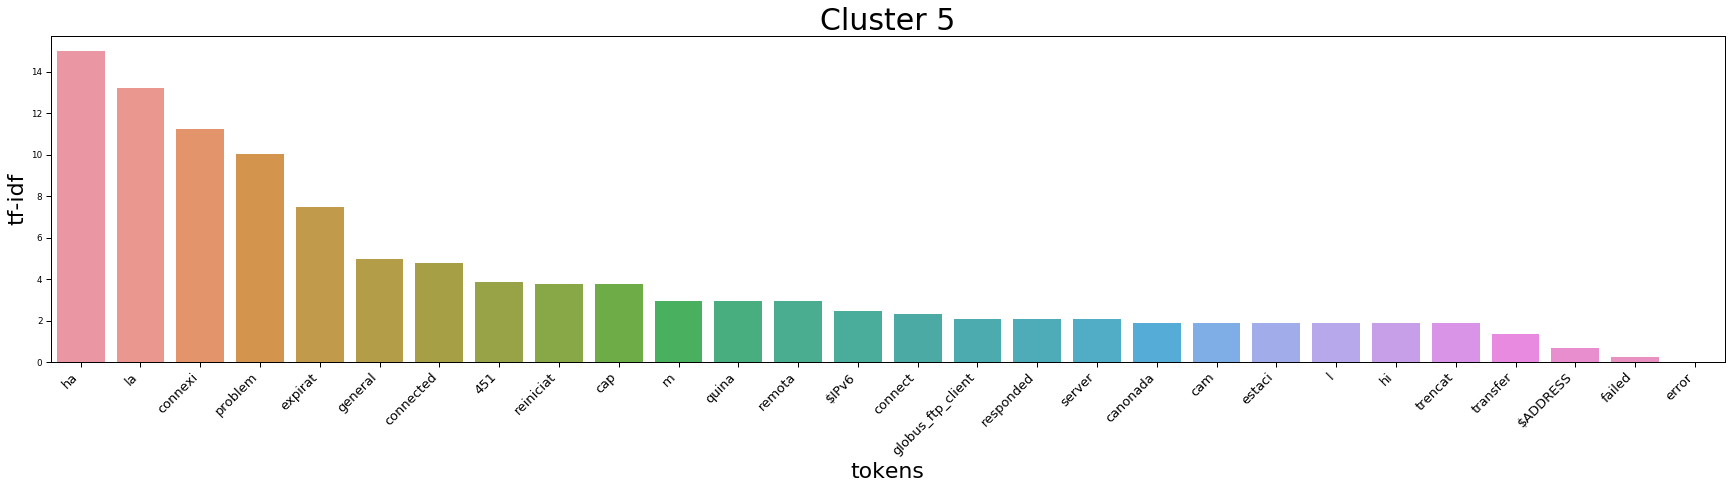

In [102]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt


sns.set_context("paper", rc={"axes.titlesize":30,"axes.labelsize":22})   
for i, row in enumerate(tks_freq.select("cluster_tokens","tf_idf", "prediction").collect()):
    
    # extract data
    y = row[1]
    x = [count_vec_model.vocabulary[x] for x in y.indices]#row[0]#.split()
    data = pd.DataFrame({"tokens": x,"tf-idf": y.values}).sort_values(by=['tf-idf'], ascending=False)
    if len(x)>100:
        font_size=9
        fig_size=(40,6)
    elif len(x)>50:
        font_size=12
        fig_size=(30,6)
    else:
        font_size=13
        fig_size=(30,6)
    fig, ax = plt.subplots(figsize=fig_size)
    _ = plt.title("Cluster {}".format(row[2]))
    g = sns.barplot(ax=ax, x="tokens", y="tf-idf", data=data, )
    
    
    _ = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=font_size)
#     _ = plt.savefig("Cluster_{}.png".format(row[2]))

### WordCloud 

## Word2Vec check 

In [70]:
a = data_subset.limit(1).select("t__error_message").collect()[0][0]
a

'TRANSFER  globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio: System error in send: Connection reset by peer  500-globus_xio: A system call failed: Connection reset by peer  500-  500 End.'

In [86]:
synonyms = w2vec_model.findSynonyms("globus_ftp_client", 10)

synonyms.show(truncate=False)

Py4JJavaError: An error occurred while calling o166.findSynonyms.
: java.lang.IllegalStateException: globus_ftp_client not in vocabulary
	at org.apache.spark.mllib.feature.Word2VecModel.transform(Word2Vec.scala:533)
	at org.apache.spark.mllib.feature.Word2VecModel.findSynonyms(Word2Vec.scala:545)
	at org.apache.spark.ml.feature.Word2VecModel.findSynonymsArray(Word2Vec.scala:273)
	at org.apache.spark.ml.feature.Word2VecModel.findSynonyms(Word2Vec.scala:237)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)


In [76]:
train_data.columns

['msg_id', 't__error_message', 'stop_token_1', 'message_vector', 'features']

In [74]:
a = train_data.limit(1).collect()[0]

In [83]:
a["t__error_message"]

'TRANSFER  globus_ftp_client: the server responded with an error 451 Space reservation 229317465 may not be used for this write request [net=2001:1458:301:4d:0:0:100:23b,protocol=GFtp/2,store=vo-atlas.ifae@enstore,cache=,linkgroup=linkgroup-atlast3]'

In [84]:
a["stop_token_1"]

['transfer',
 'globus_ftp_client',
 'server',
 'responded',
 'error',
 '451',
 'space',
 'reservation',
 '229317465',
 'may',
 'used',
 'write',
 'request',
 '[net=2001:1458:301:4d:0:0:100:23b,protocol=gftp/2,store=vo-atlas.ifae@enstore,cache=,linkgroup=linkgroup-atlast3]']

In [79]:
len(a["stop_token_1"]), len(a["message_vector"]), len(a["features"])

(14, 200, 200)

In [80]:
a["message_vector"]

DenseVector([0.1383, 0.0731, 0.0735, -0.1011, -0.2651, -0.1491, -0.0743, 0.1554, 0.0807, 0.0083, 0.0125, 0.0632, 0.0143, -0.2925, -0.1025, 0.0662, -0.0552, -0.0416, 0.4768, 0.028, 0.3636, 0.0161, -0.1932, 0.0136, 0.1203, 0.04, -0.0742, 0.0995, 0.1008, -0.1848, -0.1794, -0.1532, 0.2411, 0.061, -0.0591, 0.1438, 0.0573, 0.2359, 0.0235, -0.0542, 0.0342, -0.1296, -0.0514, -0.1395, -0.2488, 0.0153, -0.2528, -0.1863, -0.3326, 0.1942, -0.1115, 0.2059, 0.0032, -0.0932, -0.1096, -0.0338, 0.1247, 0.0659, -0.1029, -0.4558, -0.0696, -0.0091, 0.0063, -0.2967, 0.0407, -0.3435, -0.1092, -0.0012, -0.0123, 0.0415, 0.12, 0.1081, -0.1571, 0.077, 0.0684, 0.0333, 0.0216, -0.1167, 0.0642, -0.0535, 0.047, -0.0239, 0.1295, 0.1738, 0.1266, -0.2792, -0.1288, -0.0204, -0.1236, -0.1516, -0.0372, -0.0418, -0.1654, -0.0501, -0.1204, 0.5067, 0.2329, -0.1069, 0.2374, -0.2035, -0.1956, 0.0969, 0.2348, -0.2235, -0.0555, -0.1337, -0.0708, 0.0662, 0.1976, 0.0443, 0.0872, -0.2308, 0.2779, -0.0324, -0.1952, 0.1897, 0.1196, 

In [81]:
a["features"]

DenseVector([0.1383, 0.0731, 0.0735, -0.1011, -0.2651, -0.1491, -0.0743, 0.1554, 0.0807, 0.0083, 0.0125, 0.0632, 0.0143, -0.2925, -0.1025, 0.0662, -0.0552, -0.0416, 0.4768, 0.028, 0.3636, 0.0161, -0.1932, 0.0136, 0.1203, 0.04, -0.0742, 0.0995, 0.1008, -0.1848, -0.1794, -0.1532, 0.2411, 0.061, -0.0591, 0.1438, 0.0573, 0.2359, 0.0235, -0.0542, 0.0342, -0.1296, -0.0514, -0.1395, -0.2488, 0.0153, -0.2528, -0.1863, -0.3326, 0.1942, -0.1115, 0.2059, 0.0032, -0.0932, -0.1096, -0.0338, 0.1247, 0.0659, -0.1029, -0.4558, -0.0696, -0.0091, 0.0063, -0.2967, 0.0407, -0.3435, -0.1092, -0.0012, -0.0123, 0.0415, 0.12, 0.1081, -0.1571, 0.077, 0.0684, 0.0333, 0.0216, -0.1167, 0.0642, -0.0535, 0.047, -0.0239, 0.1295, 0.1738, 0.1266, -0.2792, -0.1288, -0.0204, -0.1236, -0.1516, -0.0372, -0.0418, -0.1654, -0.0501, -0.1204, 0.5067, 0.2329, -0.1069, 0.2374, -0.2035, -0.1956, 0.0969, 0.2348, -0.2235, -0.0555, -0.1337, -0.0708, 0.0662, 0.1976, 0.0443, 0.0872, -0.2308, 0.2779, -0.0324, -0.1952, 0.1897, 0.1196, 